# Setup

In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.transforms import v2
from torchvision.models.resnet import ResNet18_Weights
from torchvision.transforms.functional import InterpolationMode
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataloader

In [2]:
class DMCDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, mask_transform=None):
        '''
        '''
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.mask_transform = mask_transform
        # print('Dataloader initialized')

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image and mask
        # print('Loading image:', self.image_paths[idx])
        image = Image.open(self.image_paths[idx])
        mask = Image.open(self.mask_paths[idx])
        # print('Images loaded')

        # Convert both image and mask to tensors, apply any specified transformations
        if self.transform:
            image = self.transform(image)
            mask = self.mask_transform(mask)

        # print('Images transformed to tensors')

        # Ensure mask is a binary tensor (0 or 1 values)
        mask = (mask > 0.5).float() # Threshold mask to binary if not already

        # print('Mask thresholded')

        return image, mask

In [3]:
transform = v2.Compose([
    v2.Resize((512, 512), interpolation=InterpolationMode.BILINEAR), # Resize to match model input
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ResNet normalization
])

mask_transform = v2.Compose([
    v2.Resize((512, 512), interpolation=InterpolationMode.BILINEAR), # Resize to match model input
    v2.Grayscale(num_output_channels=1), # ensure mask is grayscale
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

In [4]:
train_size = 1000
test_size = 100
batch_size = 4

# Get paths to all images and masks
train_image_paths = glob.glob('../data/synth_data/noisy/*.png')[:train_size]
train_mask_paths = glob.glob('../data/synth_data/ground_truth/*.png')[:train_size]

test_image_paths = glob.glob('../data/synth_data/noisy/*.png')[-test_size:]
test_mask_paths = glob.glob('../data/synth_data/ground_truth/*.png')[-test_size:]

# Create dataset and dataloader
train_dataset = DMCDataset(train_image_paths, train_mask_paths, transform=transform, mask_transform=mask_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = DMCDataset(test_image_paths, test_mask_paths, transform=transform, mask_transform=mask_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

torch.Size([3, 512, 512]) torch.Size([1, 512, 512])
torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])


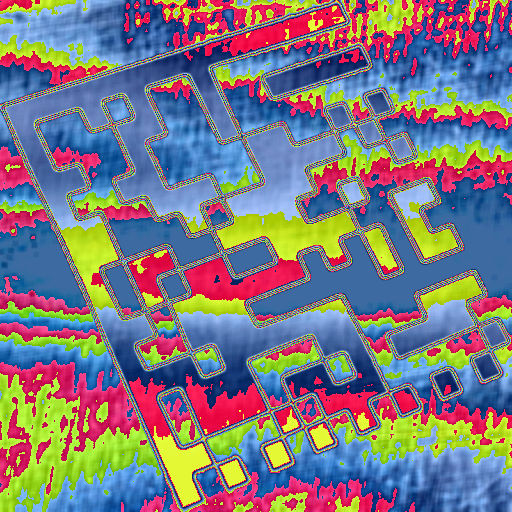

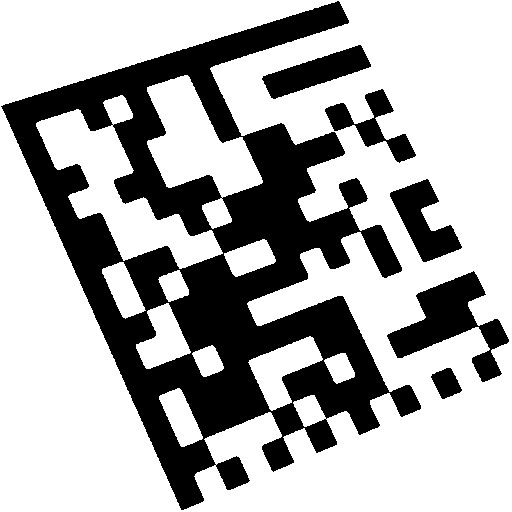

In [5]:
# train dataset example
for i, (image, mask) in enumerate(train_dataset):
    print(image.shape, mask.shape)
    break

# train Dataloader example
for i, (image, mask) in enumerate(train_dataloader):
    print(image.shape, mask.shape)
    image = v2.ToPILImage()(image[0].squeeze(0))
    display(image)

    mask = v2.ToPILImage()(mask[0].squeeze(0))
    display(mask)
    break

torch.Size([3, 512, 512]) torch.Size([1, 512, 512])
torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])


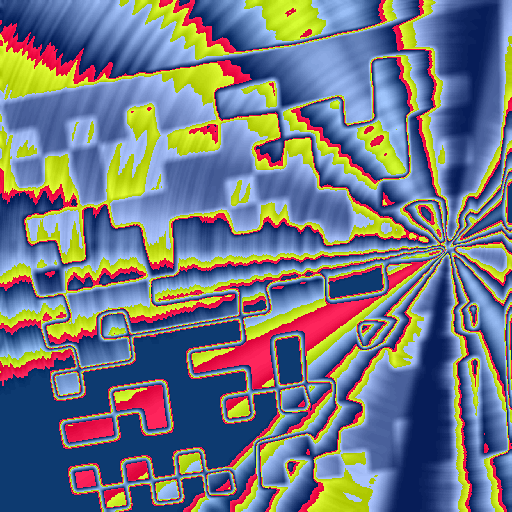

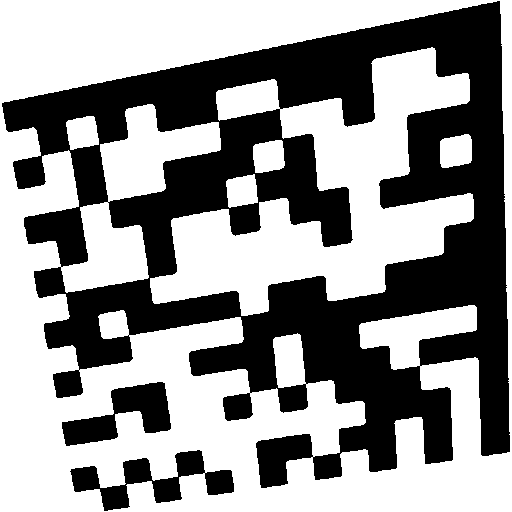

In [6]:
# test dataset example
for i, (image, mask) in enumerate(test_dataset):
    print(image.shape, mask.shape)
    break

# test Dataloader example
for i, (image, mask) in enumerate(test_dataloader):
    print(image.shape, mask.shape)
    image = v2.ToPILImage()(image[0].squeeze(0))
    display(image)

    mask = v2.ToPILImage()(mask[0].squeeze(0))
    display(mask)
    break

# Modifying Architecture

In [7]:
class binarizer(nn.Module):
    def __init__(self):
        super(binarizer, self).__init__()

        # Load the pretrained ResNet-18 model
        resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

        # Use the ResNet layers up to the last layer (remove the fully connected layer)
        self.encoder = nn.Sequential(*list(resnet18.children())[:-2]) # output size = 512 x 8 x 8

        # Define the decoder part to upsample back to 512 x 512
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() # Use sigmoid for binary output in range [0, 1]
        )

    def forward(self, x):
        '''Pass input through the resnet-18 encoder and custom decoder'''
        # print('FORWARD A')
        x = self.encoder(x)
        # print('FORWARD B')
        x = self.decoder(x)
        return x

# Training Loop

In [8]:
# setup
model = binarizer().to(device)

# params
lr = 0.0001
num_epochs = 1000

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [9]:
# Loss function - balances between two methods
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, output, target):
        smooth = 1.0  # To avoid division by zero
        output = output.contiguous().view(-1)
        target = target.contiguous().view(-1)
        intersection = (output * target).sum()
        dice = (2. * intersection + smooth) / (output.sum() + target.sum() + smooth)
        return 1 - dice

class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=1, dice_weight=1, bce_class_weights=None):
        super(BCEDiceLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCELoss(weight=bce_class_weights)
        self.dice = DiceLoss()

    def forward(self, output, target):
        bce_loss = self.bce(output, target)
        dice_loss = self.dice(output, target)
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss

In [10]:
def calculate_bce_class_weights(batch):
    '''Calculate class weights for BCE loss based on batch'''
    # Calculate class weights for BCE loss
    class_weights = batch.clone()
    for mask in batch:
        class_weights[0] += (mask == 0).sum()
        class_weights[1] += (mask == 1).sum()
    class_weights = class_weights / class_weights.sum()
    return class_weights

consider:
- adding early stopping so that we can increase epochs to a huge amount and leave running
- use more of the dataset (90/10 train/test split?)
- tweaking params (weight DMC restoration more than background denoising?)

In [11]:
# Actual training loop
prev_loss = 999999
for epoch in range(num_epochs):
    # print('EPOCH', epoch)
    model.train()
    # print('ok')
    running_loss = 0.0

    count = 0
    for inputs, masks in train_dataloader: # consider renaming masks to targets
        inputs, masks = inputs.to(device), masks.to(device)

        # print('forward pass')
        # Forward pass
        outputs = model(inputs) # Add batch dimension to input

        # print('Calculating weights for loss)
        # Calculate weights for BCE loss
        bce_class_weights = calculate_bce_class_weights(masks)
        criterion = BCEDiceLoss(bce_weight=0.5, dice_weight=1.0, bce_class_weights=bce_class_weights)

        # print('loss calculate')
        # Calculate loss
        loss = criterion(outputs, masks)

        # print('backwards pass')
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        count += batch_size
        print(f'{count}/{train_size}', end='\r')

        # if count >= 10:
            # break

    # early stopping if loss increases or stops decreasing - this allows to use a large number of epochs
    if running_loss > prev_loss or prev_loss - running_loss < 0.0001:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.4f}')
        print('Stopped early')
        break
    prev_loss = running_loss

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.4f}')

Epoch [1/1000], Loss: 0.2278
Epoch [2/1000], Loss: 0.0571
Epoch [3/1000], Loss: 0.0291
Epoch [4/1000], Loss: 0.0228
Epoch [5/1000], Loss: 0.0194
Epoch [6/1000], Loss: 0.0171
Epoch [7/1000], Loss: 0.0154
Epoch [8/1000], Loss: 0.0144
Epoch [9/1000], Loss: 0.0132
Epoch [10/1000], Loss: 0.0124
Epoch [11/1000], Loss: 0.0118
Epoch [12/1000], Loss: 0.0114
Epoch [13/1000], Loss: 0.0108
Epoch [14/1000], Loss: 0.0103
Epoch [15/1000], Loss: 0.0098
Epoch [16/1000], Loss: 0.0097
Epoch [17/1000], Loss: 0.0094
Epoch [18/1000], Loss: 0.0090
Epoch [19/1000], Loss: 0.0086
Epoch [20/1000], Loss: 0.0086
Stopped early


# Evaluation

Output range: min=0.0, max=1.0
Output range after binarization: min=0.0, max=1.0
Mean IoU: 0.2443
Mean Dice Coefficient: 0.2471
Mean Pixel Accuracy: 0.2464


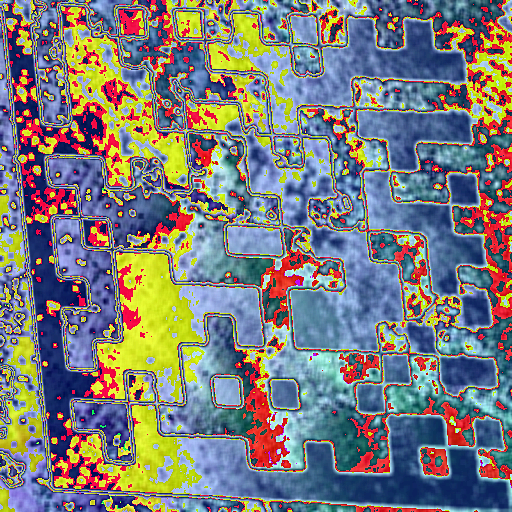

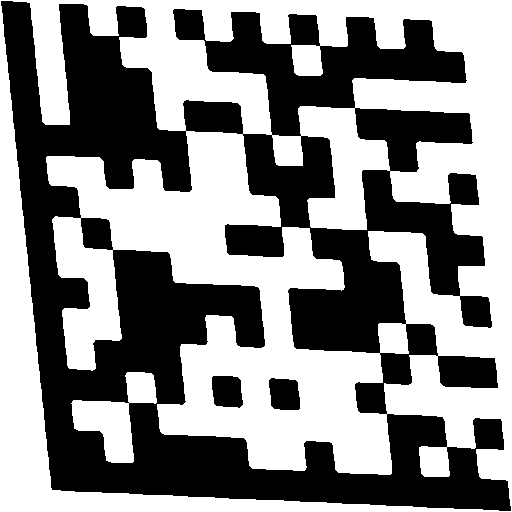

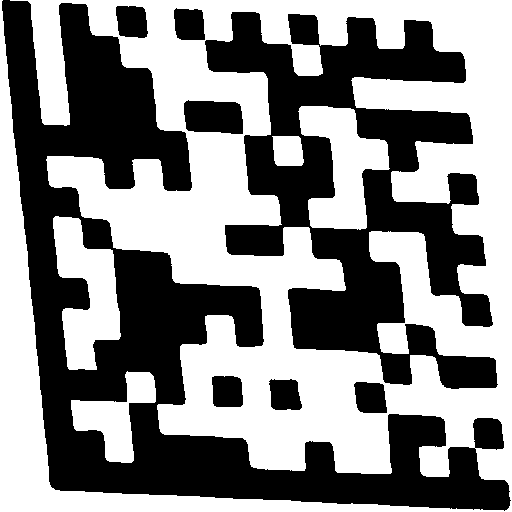

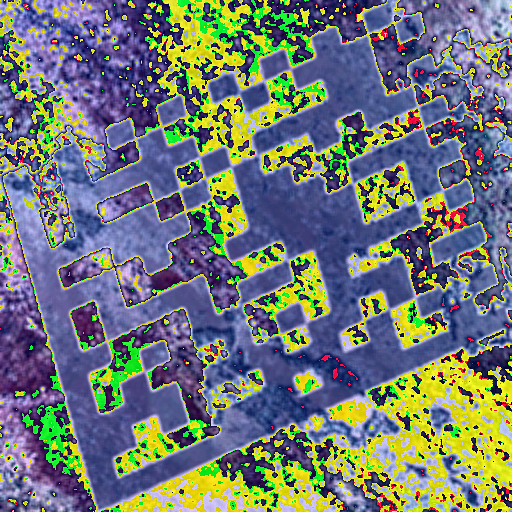

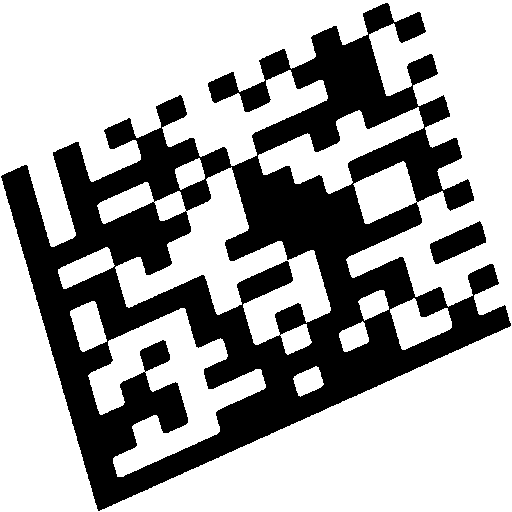

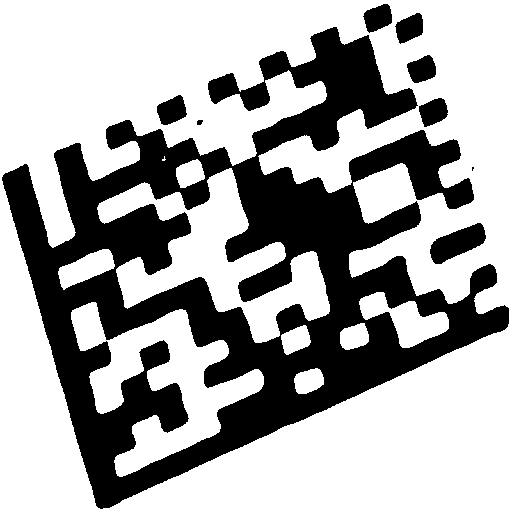

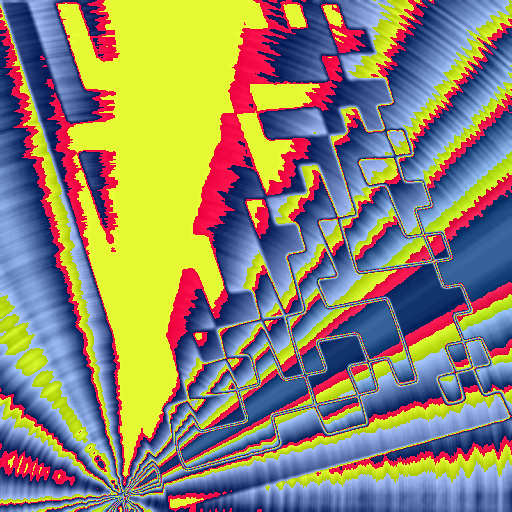

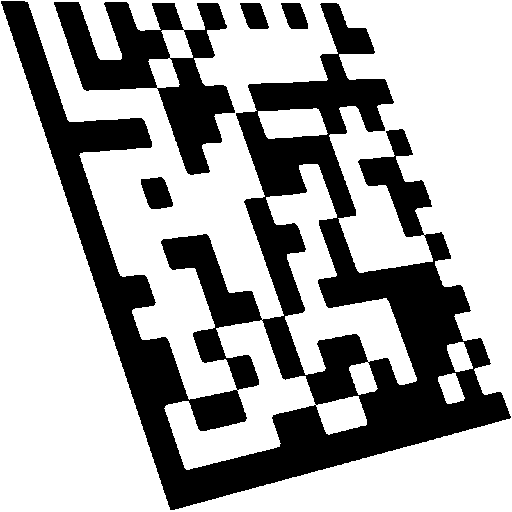

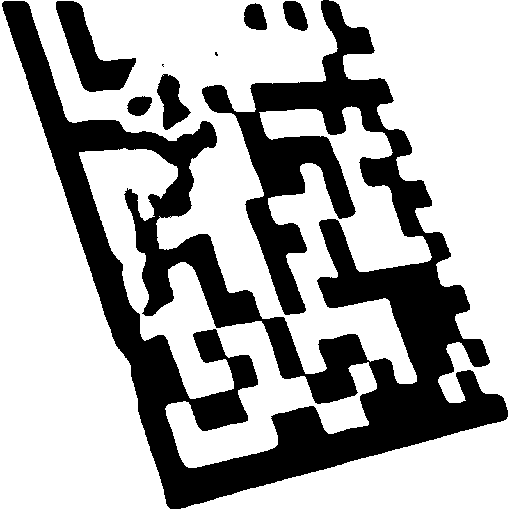

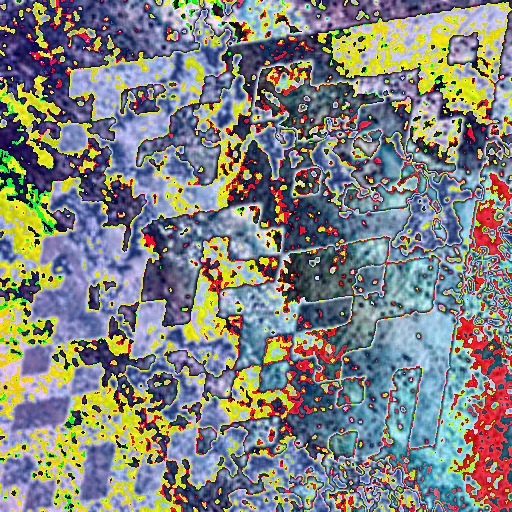

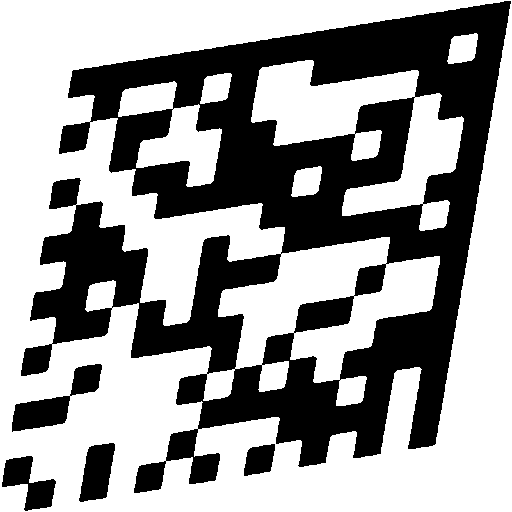

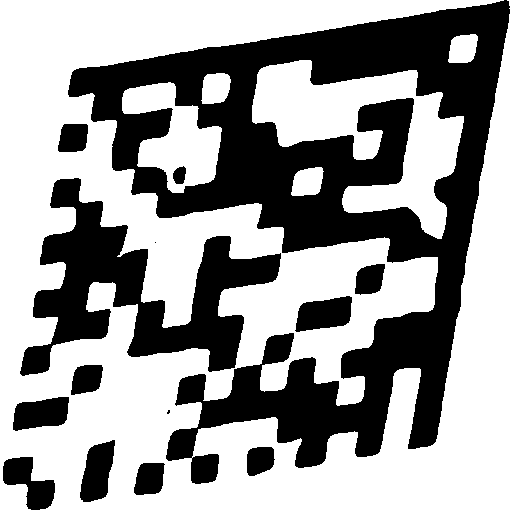

(0.24428879618644714, 0.2471025025844574, 0.24638091087341307)

In [14]:
# Assuming you have a test DataLoader providing (images, ground_truth_masks)
def evaluate_model(model, test_loader, threshold=0.5):
    model.eval()  # Set model to evaluation mode

    iou_total = 0
    dice_total = 0
    accuracy_total = 0
    count = 0

    with torch.no_grad():  # No need to compute gradients for evaluation
        for images, ground_truths in test_loader:
            # Move data to the same device as the model
            images = images.to(device)
            ground_truths = ground_truths.to(device)

            # Forward pass
            outputs = model(images)

            # Binarize the outputs
            predictions = (outputs > threshold).float() # Binarize predictions

            # predictions = outputs # inspect the output pre binarization

            # Calculate IoU
            intersection = (predictions * ground_truths).sum((1, 2, 3))
            union = (predictions + ground_truths).sum((1, 2, 3)) - intersection
            iou = (intersection / union).mean()  # Mean IoU for batch
            iou_total += iou.item()

            # Calculate Dice Coefficient
            dice = (2 * intersection / (predictions.sum((1, 2, 3)) + ground_truths.sum((1, 2, 3)))).mean()
            dice_total += dice.item()

            # Calculate Pixel Accuracy
            correct = (predictions == ground_truths).float().sum()
            accuracy = correct / ground_truths.numel()
            accuracy_total += accuracy.item()

            count += batch_size
            print(f'{count}/{test_size}', end='\r')

            if count >= 100:
                break

    # debug print
    print(f'Output range: min={outputs.min().item()}, max={outputs.max().item()}')
    print(f'Output range after binarization: min={predictions.min().item()}, max={predictions.max().item()}')

    # Average the metrics over the whole test set
    mean_iou = iou_total / count
    mean_dice = dice_total / count
    mean_accuracy = accuracy_total / count

    print(f'Mean IoU: {mean_iou:.4f}')
    print(f'Mean Dice Coefficient: {mean_dice:.4f}')
    print(f'Mean Pixel Accuracy: {mean_accuracy:.4f}')

    # show batch of images
    for i in range(4):
        image = v2.ToPILImage()(images[i].squeeze(0))
        mask = v2.ToPILImage()(ground_truths[i].squeeze(0))
        pred = v2.ToPILImage()(predictions[i].squeeze(0))
        display(image)
        display(mask)
        display(pred)

        # image.save('../figures/binarization/failure_noisy.png')
        # mask.save('../figures/binarization/failure_ground_truth.png')
        # pred.save('../figures/binarization/failure_prediction.png')

    return mean_iou, mean_dice, mean_accuracy

evaluate_model(model, test_dataloader, threshold=0.5)

In [15]:
# Save the model
torch.save(model.state_dict(), 'model.pth')